## Ensemble Hybrid deep learning model for HAR on  WISDM Dataset

In [34]:
##model_wisdm.py
import numpy as np
import pandas as pd
#import seaborn as sns

In [35]:
#preprocess data 
def preprocess(data):
    #column_names = ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = pd.read_csv(data,on_bad_lines='skip',index_col=False)
    df.columns= ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = df.dropna() # removing null values
    df['z_axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'') # Transforming the z-axis to float
    
    #### Label encoding 
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['label'] = label.fit_transform(df['activity'])
    
    ##Balanace this Data :Under sampling
    Walking = df[df['activity']=='Walking'].head(48394).copy()
    Jogging = df[df['activity']=='Jogging'].head(48394).copy()
    Upstairs = df[df['activity']=='Upstairs'].head(48394).copy()
    Downstairs = df[df['activity']=='Downstairs'].head(48394).copy()
    Sitting = df[df['activity']=='Sitting'].head(48394).copy()
    Standing = df[df['activity']=='Standing'].copy()
    
    #df_balanced = pd.DataFrame()
    df_balanced = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
    
    ##Normalize/Standardized data
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    X = df_balanced[['x_axis', 'y_axis', 'z_axis']]
    target = df_balanced['label']
    scaler = StandardScaler()
    dx = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(data = dx, columns = X.columns)
    df_scaled['label'] = target.values
    return df_scaled

In [36]:
dff=preprocess('WISDM_dataset_raw.txt')
#dff.head()

In [37]:
## Segmenting samples (windowing) functions 
import scipy.stats as stats
Fs = 20
segment_size =  128# Fs*4 # window size=n_time steps=frame size
step_size =  25 # Fs*2  # step size 
n_features = 3     

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(df) - segment_size - 1, step_size):
        xs = dff['x_axis'].values[i: i + segment_size]
        ys = dff['y_axis'].values[i: i + segment_size]
        zs = dff['z_axis'].values[i: i + segment_size]
        label = stats.mode(dff['label'][i: i + segment_size])[0][0] # [0][0] shows the index of the current sequence
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([xs, ys, zs]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
                
    return segments, labels

In [38]:
X, y = get_segments(dff, segment_size, step_size)

In [39]:
X.shape, y.shape

((11610, 128, 3), (11610, 6))

In [40]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

In [41]:
# split training set into training and validation set
from sklearn.model_selection import train_test_split
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [42]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((6501, 4, 32, 3), (2322, 4, 32, 3), (6501, 6), (2322, 6))

###  Load  Models

In [43]:
#dependencies = {'f1_m': f1_m }

In [44]:
from keras import models    

In [45]:
# create a custom function to load model
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models-1):
        # Specify the filename
        filename = './Models/model' + str(i + 1) + '.h5'
        # load the model 
        model = models.load_model(filename)
        # Add a list of all the weaker learners
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [46]:
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded ./Models/model1.h5
>loaded ./Models/model2.h5
>loaded ./Models/model3.h5
>loaded ./Models/model4.h5
Loaded 4 models


In [47]:
from sklearn.metrics import accuracy_score,classification_report

### Evaluate standalone models on test dataset

In [48]:
# evaluate standalone models on test dataset
for model in members:
        y_preds = model.predict(X_test) #class Prediction
        
        y_pred_test=np.argmax(y_preds,axis=1) 
        y_true_test=np.argmax(y_test,axis=1) 
        
        print("Test  acc : {}".format(accuracy_score(y_true_test, y_pred_test)))
        print("\n -------------Classification Report-------------\n")
        #print(classification_report(y_true_test, y_pred_test))

73/73 [==============================] - 1s 5ms/step
Test  acc : 0.9866494401378122

 -------------Classification Report-------------

73/73 [==============================] - 1s 3ms/step
Test  acc : 0.983634797588286

 -------------Classification Report-------------

73/73 [==============================] - 1s 5ms/step
Test  acc : 0.975452196382429

 -------------Classification Report-------------

73/73 [==============================] - 1s 5ms/step
Test  acc : 0.9776055124892334

 -------------Classification Report-------------



### Running the member models to make predictions on the validation set, and create a new training set with the resulting predictions

In [49]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat #
		else:
			stackX = np.dstack((stackX, yhat)) # stack preditions 
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 

In [51]:
# defining parameter range 
param_grid = {
    #'bootstrap': [True],
    #'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

In [52]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    inputy=np.argmax(inputy,axis=1) 
    # fit the meta learner
    #model = GradientBoostingClassifier(n_estimators=100) #meta learner
    rf=RandomForestClassifier()
    model = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 5, ) # Instantiate the grid search model with CV=10
    model.fit(stackedX, inputy)
    return model

In [53]:
model = fit_stacked_model(members, X_valid,y_valid) # predictions on validation set

### Make  prediction with the stacked model

In [54]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [55]:
# evaluate model on test set
y_pred_test = stacked_prediction(members, model, X_test)

In [56]:
y_true_test=np.argmax(y_test,axis=1) 

In [57]:
acc = accuracy_score(y_true_test, y_pred_test)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.994


In [58]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[363   0   0   0   4   0]
 [  1 396   0   0   0   0]
 [  0   0 386   2   0   0]
 [  0   0   1 375   0   0]
 [  5   1   0   0 406   0]
 [  0   0   0   0   0 382]]
0.9939707149009475
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       1.00      1.00      1.00       397
           2       1.00      0.99      1.00       388
           3       0.99      1.00      1.00       376
           4       0.99      0.99      0.99       412
           5       1.00      1.00      1.00       382

    accuracy                           0.99      2322
   macro avg       0.99      0.99      0.99      2322
weighted avg       0.99      0.99      0.99      2322



In [59]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [60]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

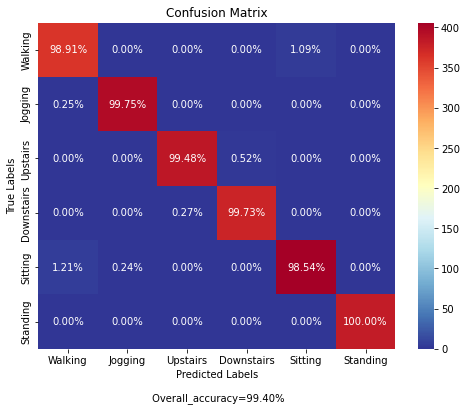

In [61]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_true_test,y_pred_test)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [62]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9939293048389629, 0.9940341008852626, 0.9939789450303324, None)

In [63]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

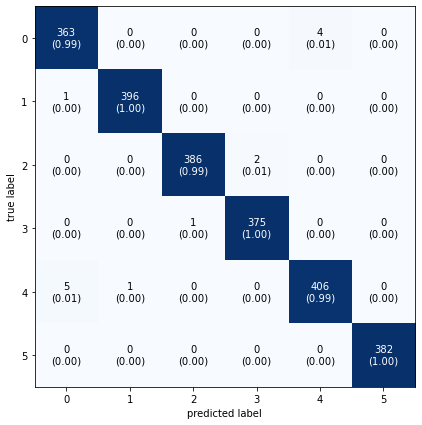

In [64]:
mat = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(conf_mat=mat,show_normed=True, figsize=(7,7))